In [2]:
pip -q install mlflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.6 MB/s eta 0:00:00


In [3]:
pip -q install hyperopt

In [4]:
#!pip install -q mlflow databricks-sdk

In [5]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import os
from google.colab import drive
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder,OneHotEncoder,RobustScaler,MinMaxScaler
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,classification_report, confusion_matrix,log_loss
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.naive_bayes import GaussianNB,BernoulliNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV,StratifiedKFold,cross_val_score
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer,SimpleImputer
from xgboost import plot_importance
from sklearn.metrics import make_scorer
from hyperopt import hp,tpe, fmin,Trials, STATUS_OK
np.random.seed(0)

In [6]:
mlflow.login()

2024/01/01 05:14:30 INFO mlflow.utils.credentials: No valid Databricks credentials found, please enter your credentials...


Databricks Host (should begin with https://): https://community.cloud.databricks.com/
Username: abishek.balaji@utdallas.edu
Password: ··········


In [7]:
# Mount Google Drive (if not already mounted)
drive.mount('/content/drive')
#Get the current notebook's path to log it as part of the mlflow runs later on
notebook_path = '/content/drive/MyDrive/Colab Notebooks/Multi-Class Prediction of Cirrhosis Outcomes v1 with mlflow.ipynb'

Mounted at /content/drive


In [50]:
df1 = pd.read_csv("train.csv")
df2 = pd.read_csv("cirrhosis.csv")

In [51]:
df2.shape

(418, 20)

In [52]:
df_test = pd.read_csv("test.csv")
test_IDs = df_test.id
df_test = df_test.drop("id", axis=1)

In [53]:
df2.rename(columns={'ID': 'id'}, inplace=True)

In [54]:
df = df1.append(df2)

<ipython-input-54-68017848d1f5>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df1.append(df2)


In [55]:
df.drop('id', axis=1, inplace=True)

In [56]:
df.reset_index(drop=True, inplace=True)

In [57]:
df.isna().sum()

N_Days             0
Drug             106
Age                0
Sex                0
Ascites          106
Hepatomegaly     106
Spiders          106
Edema              0
Bilirubin          0
Cholesterol      134
Albumin            0
Copper           108
Alk_Phos         106
SGOT             106
Tryglicerides    136
Platelets         11
Prothrombin        2
Stage              6
Status             0
dtype: int64

In [58]:
# KNN Imputation for Numerical Columns

categorical_columns= ["Drug", "Sex", "Ascites", "Hepatomegaly", "Spiders", "Edema", "Stage"]
numerical_columns = [x for x in df.columns if x not in categorical_columns and x != 'Status']
knn_imputer = KNNImputer()
df[numerical_columns] = knn_imputer.fit_transform(df[numerical_columns])

# Simple Imputation for Categorical Columns (replace with the mode)
categorical_imputer = SimpleImputer(strategy='most_frequent')
df[categorical_columns] = categorical_imputer.fit_transform(df[categorical_columns])

In [59]:
df['Stage'] = df['Stage'].astype('int')

In [60]:
#df.dropna(axis=0, how='any', inplace=True)
df.isna().sum()

N_Days           0
Drug             0
Age              0
Sex              0
Ascites          0
Hepatomegaly     0
Spiders          0
Edema            0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
Status           0
dtype: int64

In [61]:
df_drug_encoded =  pd.get_dummies(df['Drug'],prefix = 'Drug_Presence', columns =['Drug'])
df = pd.concat([df, df_drug_encoded], axis=1)
df = df.drop(['Drug'], axis=1)

df_test_drug_encoded = pd.get_dummies(df_test['Drug'],prefix = 'Drug_Presence', columns =['Drug'])
df_test = pd.concat([df_test, df_test_drug_encoded], axis=1)
df_test = df_test.drop(['Drug'], axis=1)

df_sex_encoded =  pd.get_dummies(df['Sex'],prefix = 'Drug_Presence', columns =['Sex'])
df = pd.concat([df, df_sex_encoded], axis=1)
df = df.drop(['Sex'], axis=1)

df_test_sex_encoded = pd.get_dummies(df_test['Sex'],prefix = 'Drug_Presence', columns =['Sex'])
df_test = pd.concat([df_test, df_test_sex_encoded], axis=1)
df_test = df_test.drop(['Sex'], axis=1)

df_ascites_encoded =  pd.get_dummies(df['Ascites'],prefix = 'Ascites_Presence', columns =['Ascites'])
df = pd.concat([df, df_ascites_encoded], axis=1)
df = df.drop(['Ascites'], axis=1)

df_test_ascites_encoded = pd.get_dummies(df_test['Ascites'],prefix = 'Ascites_Presence', columns =['Ascites'])
df_test = pd.concat([df_test, df_test_ascites_encoded], axis=1)
df_test = df_test.drop(['Ascites'], axis=1)

df_hepatomegaly_encoded =  pd.get_dummies(df['Hepatomegaly'],prefix = 'Hepatomegaly_Presence', columns =['Hepatomegaly'])
df = pd.concat([df, df_hepatomegaly_encoded], axis=1)
df = df.drop(['Hepatomegaly'], axis=1)

df_test_hepatomegaly_encoded = pd.get_dummies(df_test['Hepatomegaly'],prefix = 'Hepatomegaly_Presence', columns =['Hepatomegaly'])
df_test = pd.concat([df_test, df_test_hepatomegaly_encoded], axis=1)
df_test = df_test.drop(['Hepatomegaly'], axis=1)


df_spiders_encoded =  pd.get_dummies(df['Spiders'],prefix = 'Spiders_Presence', columns =['Spiders'])
df = pd.concat([df, df_spiders_encoded], axis=1)
df = df.drop(['Spiders'], axis=1)

df_test_spiders_encoded = pd.get_dummies(df_test['Spiders'],prefix = 'Spiders_Presence', columns =['Spiders'])
df_test = pd.concat([df_test, df_test_spiders_encoded], axis=1)
df_test = df_test.drop(['Spiders'], axis=1)

df_edema_encoded =  pd.get_dummies(df['Edema'],prefix = 'Edema_Presence', columns =['Edema'])
df = pd.concat([df, df_edema_encoded], axis=1)
df = df.drop(['Edema'], axis=1)

df_test_edema_encoded = pd.get_dummies(df_test['Edema'],prefix = 'Edema_Presence', columns =['Edema'])
df_test = pd.concat([df_test, df_test_edema_encoded], axis=1)
df_test = df_test.drop(['Edema'], axis=1)

status_le = OrdinalEncoder().fit(df[['Status']])
df['Status'] = status_le.transform(df[['Status']])

In [62]:
df['Status'].value_counts()

0.0    5197
2.0    2826
1.0     300
Name: Status, dtype: int64

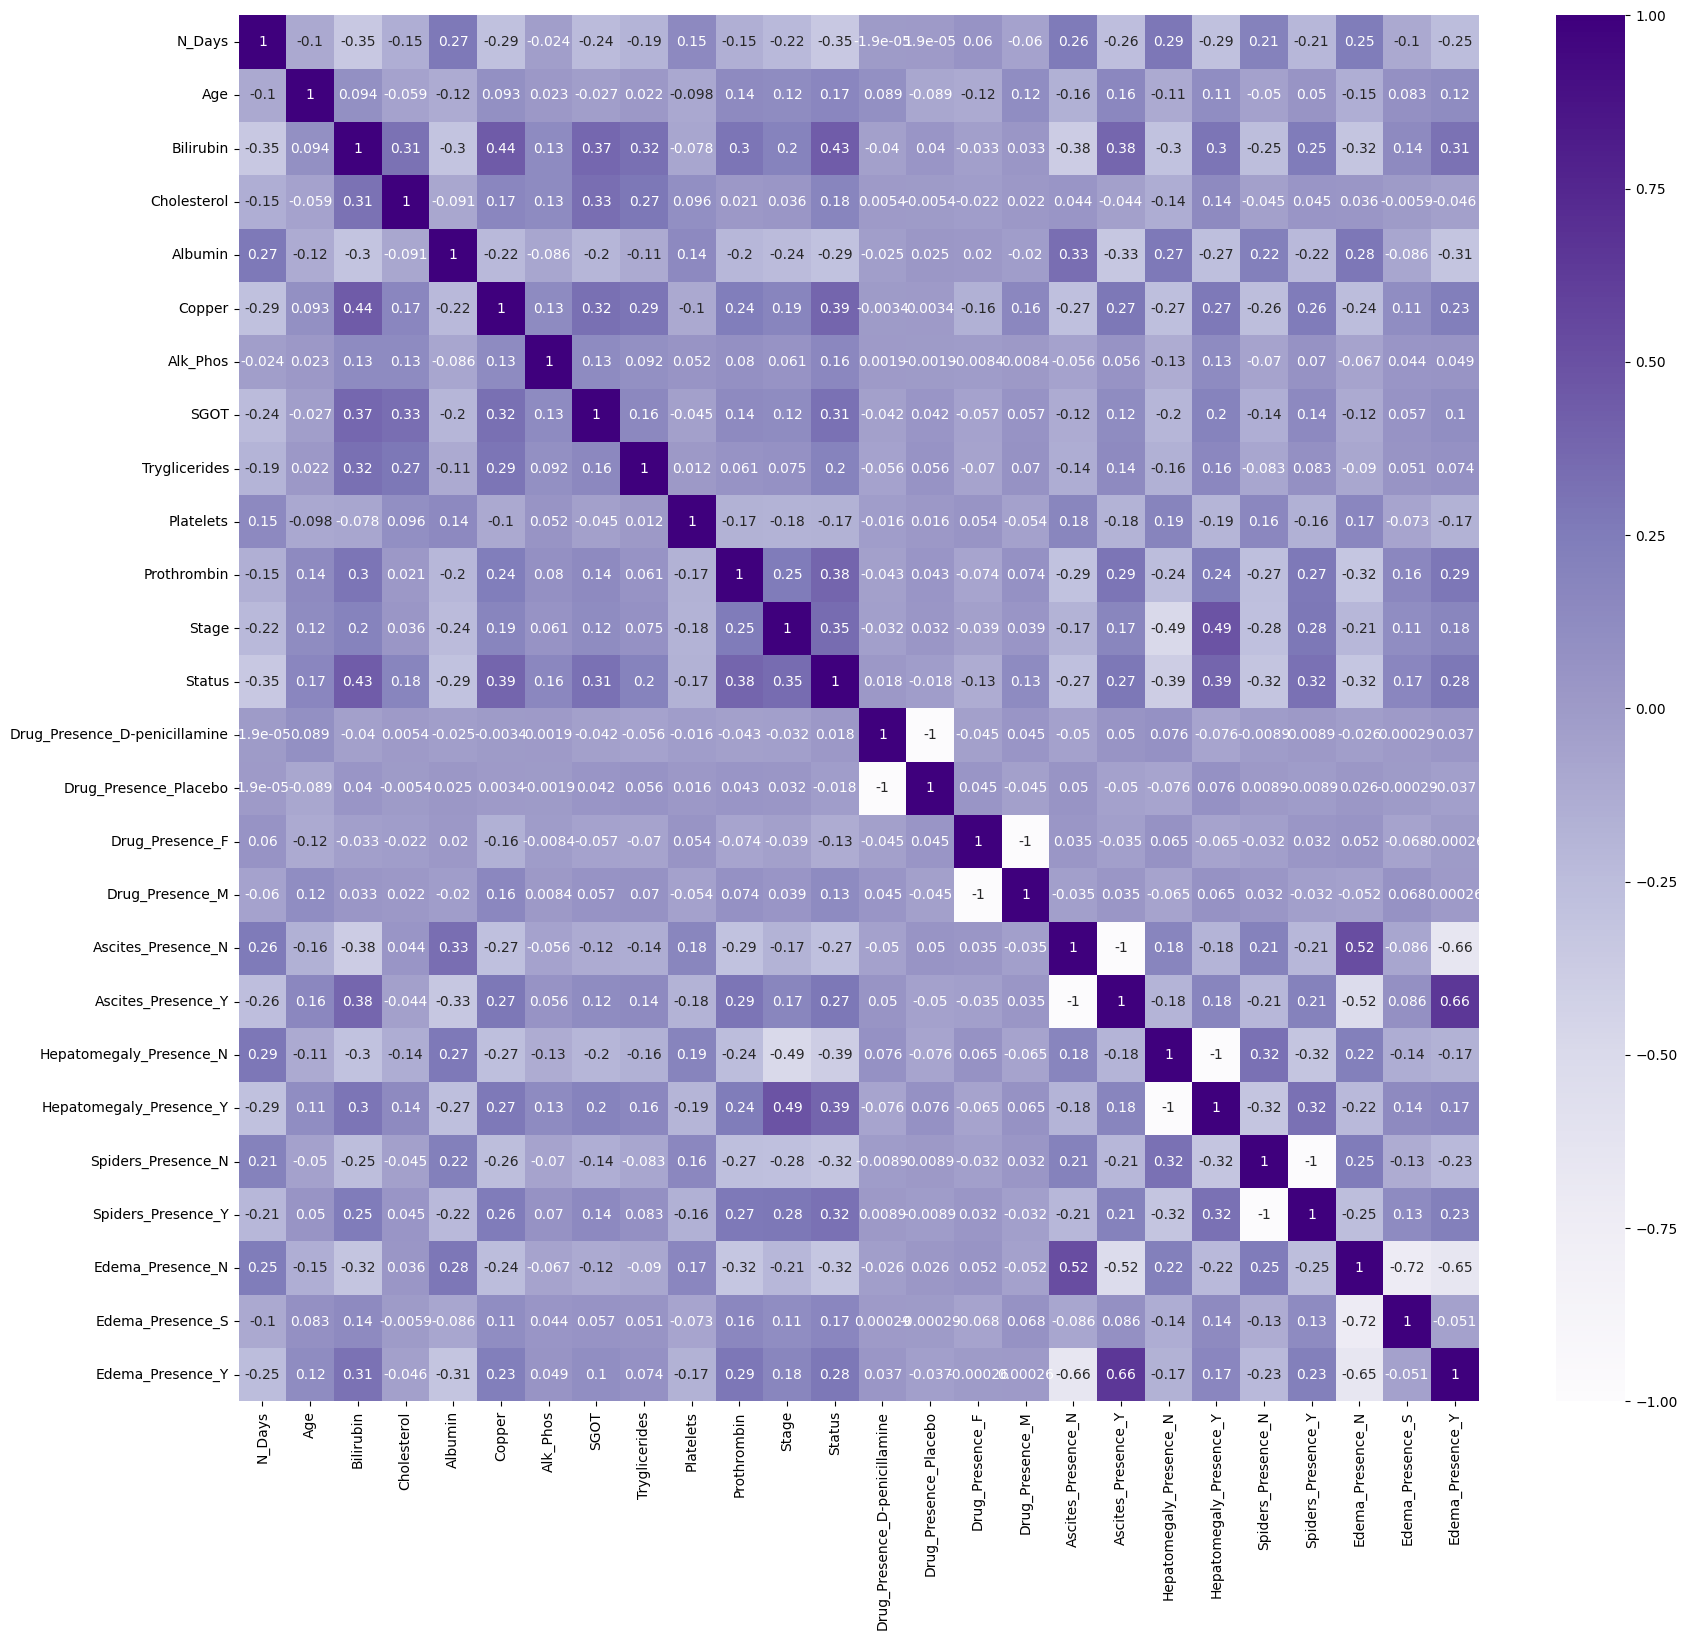

In [63]:
plt.figure(figsize=(20,18))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Purples)
plt.show()

In [64]:
cor_target = abs(cor["Status"])
relevant_features = cor_target[cor_target>0.1]
relevant_features

N_Days                     0.347622
Age                        0.169746
Bilirubin                  0.429864
Cholesterol                0.184215
Albumin                    0.294319
Copper                     0.385334
Alk_Phos                   0.157444
SGOT                       0.312911
Tryglicerides              0.198995
Platelets                  0.168716
Prothrombin                0.384752
Stage                      0.345045
Status                     1.000000
Drug_Presence_F            0.130532
Drug_Presence_M            0.130532
Ascites_Presence_N         0.274364
Ascites_Presence_Y         0.274364
Hepatomegaly_Presence_N    0.389299
Hepatomegaly_Presence_Y    0.389299
Spiders_Presence_N         0.318081
Spiders_Presence_Y         0.318081
Edema_Presence_N           0.323581
Edema_Presence_S           0.171006
Edema_Presence_Y           0.280379
Name: Status, dtype: float64

In [65]:
#df_afterfe=df[['N_Days', 'Age', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders',
#       'Edema', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos',
#       'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage', 'Status']]
df_afterfe=df

In [66]:
X = df_afterfe.drop("Status", axis=1)
y = df_afterfe["Status"]
print(X.shape)
print(y.shape)

(8323, 25)
(8323,)


In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print("Training set size: {}".format(X_train.shape))
print("Testing set size: {}".format(X_test.shape))

Training set size: (6658, 25)
Testing set size: (1665, 25)


In [68]:
min_max_scaler = MinMaxScaler()
robust_scaler = RobustScaler()
X_train[['N_Days','Age',]] = min_max_scaler.fit_transform(X_train[['N_Days','Age']])
X_test[['N_Days','Age']] = min_max_scaler.transform(X_test[['N_Days','Age']])
df_test[['N_Days','Age']] = min_max_scaler.transform(df_test[['N_Days','Age']])

X_train[['Bilirubin','Cholesterol','Albumin','Copper','Alk_Phos','SGOT','Tryglicerides','Platelets','Prothrombin']] = robust_scaler.fit_transform(X_train[['Bilirubin','Cholesterol','Albumin','Copper','Alk_Phos','SGOT','Tryglicerides','Platelets','Prothrombin']])
X_test[['Bilirubin','Cholesterol','Albumin','Copper','Alk_Phos','SGOT','Tryglicerides','Platelets','Prothrombin']] = robust_scaler.transform(X_test[['Bilirubin','Cholesterol','Albumin','Copper','Alk_Phos','SGOT','Tryglicerides','Platelets','Prothrombin']])
df_test[['Bilirubin','Cholesterol','Albumin','Copper','Alk_Phos','SGOT','Tryglicerides','Platelets','Prothrombin']] = robust_scaler.transform(df_test[['Bilirubin','Cholesterol','Albumin','Copper','Alk_Phos','SGOT','Tryglicerides','Platelets','Prothrombin']])

In [69]:
scoring_metric = make_scorer(log_loss, needs_proba=True, greater_is_better=False)

score_log = pd.DataFrame()
def score(model, name , x_test, y_test, position):
    y_pred = model.predict(x_test)
    pred = model.predict_proba(x_test)
    y_pred = y_pred.reshape(-1,)
    compare_results = pd.DataFrame({"Actual": y_test, "Predicted": y_pred})
    print("Confusion matrix: \n",confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print(compare_results)
    score_log.loc[position, "Model"] = name
    score_log.loc[position, "Accuracy"] = round(accuracy_score(y_test, y_pred), 2)
    score_log.loc[position, "Precision"] = round(precision_score(y_test, y_pred, average='weighted'), 2)
    score_log.loc[position, "Recall"] = round(recall_score(y_test, y_pred, average='weighted'), 2)
    score_log.loc[position, "F1-Score"] = round(f1_score(y_test, y_pred, average='weighted'), 2)
    score_log.loc[position, "LogLoss"] = round(log_loss(y_test, pred), 5)
    return score_log

In [70]:
def submission_file(model):
  sub = pd.DataFrame()
  submission_predictions = model.predict_proba(df_test)
  # print(submission_predictions)
  sub = pd.DataFrame({"id": test_IDs, **dict(zip(submission_labels, submission_predictions.T))})
  return sub

In [71]:
# Set our tracking server uri for logging

def log_with_mlflow_tracking(experiment_name,run_name,params = None,metrics = None, training_notebook_path = None,tags_dict= None,sub_file_path = None):
    """
    experiment_name - The name you want to give to an experiment(naming conventions dictate that the experiment name be specified like a relative path
    eg. '/sample-exp')
    run_name - The name you want to give the run you are creating within an experiment
    params - dictionary of the model hyperparameters you set(with keys being the parameter/hyperparamater name and
    the value being it's value)
    metrics - dictionary of the evaluation metrics you want to log(with keys being the scoring metric name and the value being the metric value)
    training_notebook_path - The path of the notebook where the training code was run and needs to be logged for future reference
    tags_dict - The tags to attach to each run. Should be a dictionary of tags that is passed
    sub_file_path - The submission file to upload for submission on Kaggle
    """
    mlflow.set_tracking_uri("databricks")
    # Create a new MLflow Experiment
    mlflow.set_experiment(experiment_name)
    # Start an MLflow run
    with mlflow.start_run(run_name = run_name):
        # Log the model hyperparameters
        if params is not None:
            mlflow.log_params(params)
        # Log the evaluation metrics
        mlflow.log_metrics(metrics)
        # Set a tag that we can use to remind ourselves what this run was for
        if tags_dict is not None:
          for key, value in tags_dict.items():
              mlflow.set_tag(key, value)
        if training_notebook_path is not None:
            mlflow.log_artifact(training_notebook_path)
        if sub_file_path is not None:
            mlflow.log_artifact(sub_file_path)


In [72]:
"""parameters = {'max_features':(["sqrt"]), 'criterion':("gini", "entropy", "log_loss"),  'max_depth':[10, 30, 40, 50, 70, 100, 150], }
rfc = RandomForestClassifier()
rf_grid_search_cv = GridSearchCV(rfc,parameters,scoring = scoring_metric,return_train_score = True,cv = StratifiedKFold(n_splits=5, shuffle=True),n_jobs = -1)
rf_grid_search_cv.fit(X_train,y_train)
rf_grid_search_cv_scores = (score(rf_grid_search_cv,"Grid Search Random Forest Classfier", X_test, y_test, 8))"""

'parameters = {\'max_features\':(["sqrt"]), \'criterion\':("gini", "entropy", "log_loss"),  \'max_depth\':[10, 30, 40, 50, 70, 100, 150], }\nrfc = RandomForestClassifier()\nrf_grid_search_cv = GridSearchCV(rfc,parameters,scoring = scoring_metric,return_train_score = True,cv = StratifiedKFold(n_splits=5, shuffle=True),n_jobs = -1)\nrf_grid_search_cv.fit(X_train,y_train)\nrf_grid_search_cv_scores = (score(rf_grid_search_cv,"Grid Search Random Forest Classfier", X_test, y_test, 8))'

In [73]:
"""rf_grid_search_cv_temp_dict = rf_grid_search_cv.get_params()
keys = ['estimator__max_features','estimator__criterion','estimator__max_depth']
rf_grid_search_cv_dict = {}
for key in keys:
    rf_grid_search_cv_dict[key] = rf_grid_search_cv_temp_dict[key]
rf_grid_search_cv_dict['max_features'] = rf_grid_search_cv_dict.pop('estimator__max_features')
rf_grid_search_cv_dict['criterion'] = rf_grid_search_cv_dict.pop('estimator__criterion')
rf_grid_search_cv_dict['max_depth'] = rf_grid_search_cv_dict.pop('estimator__max_depth')"""

"rf_grid_search_cv_temp_dict = rf_grid_search_cv.get_params()\nkeys = ['estimator__max_features','estimator__criterion','estimator__max_depth']\nrf_grid_search_cv_dict = {}\nfor key in keys:\n    rf_grid_search_cv_dict[key] = rf_grid_search_cv_temp_dict[key]\nrf_grid_search_cv_dict['max_features'] = rf_grid_search_cv_dict.pop('estimator__max_features')\nrf_grid_search_cv_dict['criterion'] = rf_grid_search_cv_dict.pop('estimator__criterion')\nrf_grid_search_cv_dict['max_depth'] = rf_grid_search_cv_dict.pop('estimator__max_depth')"

In [74]:
"""rf_grid_search_cv_metrics_dict = rf_grid_search_cv_scores.iloc[4].to_dict()
rf_grid_search_cv_metrics_dict.pop('Model')
rf_grid_search_cv_metrics_dict"""

"rf_grid_search_cv_metrics_dict = rf_grid_search_cv_scores.iloc[4].to_dict()\nrf_grid_search_cv_metrics_dict.pop('Model')\nrf_grid_search_cv_metrics_dict"

In [75]:
"""sub = submission_file(rf_grid_search_cv)
sub.to_csv('submission.csv', index=False)"""

"sub = submission_file(rf_grid_search_cv)\nsub.to_csv('submission.csv', index=False)"

In [76]:
#log_with_mlflow_tracking("/Baseline Models",'Random Forest tuned with grid search: Baseline Model - Edema OHE and custom outlier removal Run',rf_grid_search_cv_dict,rf_grid_search_cv_metrics_dict,notebook_path,None,'submission.csv')

In [77]:
#Define the objective function to tune the heperparameters of the XGBoost model with hyperopt
def objective_function(params):
    xgb_clf = XGBClassifier(**params)
    score = cross_val_score(xgb_clf, X_train, y_train, cv=StratifiedKFold(n_splits=5, shuffle=True),scoring = scoring_metric,n_jobs = -1,error_score = 'raise').mean()
    print(score)
    return {'loss': -score , 'status': STATUS_OK}

In [78]:
max_depth_space_choices = np.arange(1, 16, dtype=int)
n_estimators_space_choices = np.arange(150, 401, dtype=int)
space= {
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.2),
    'max_depth': hp.choice('max_depth', max_depth_space_choices),
    'n_estimators': hp.choice('n_estimators', n_estimators_space_choices),
    'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'gamma': hp.uniform ('gamma', 0,9),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.5, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
}

In [79]:
tpe_algorithm = tpe.suggest
#Define the maximum number of iterations to take
num_eval = 500
trials = Trials()
best_param = fmin(objective_function, space, algo=tpe.suggest, max_evals=num_eval, trials=trials)

-0.47712638423952375
-0.4619978036444934
-0.4851050025823316
-0.478375223949822
-0.47967649020075565
-0.48666429724262966
-0.4883316664716711
-0.46110163990385844
-0.48695106719811465
-0.47553419554015475
-0.4525112182823873
-0.4750274519878374
-0.548181626102882
-0.459864140429049
-0.4736792718678813
-0.46955686224059995
-0.46783531826527974
-0.4827790166268616
-0.4835689065435371
-0.44668639702308977
-0.4676175044809246
-0.553066463389704
-0.446093678066841
-0.45113129430557547
-0.4479241840949582
-0.4519282353843005
-0.4465623987049631
-0.45862748755768745
-0.5965700959113427
-0.4561366260967656
-0.46088576898631883
-0.45541904099081965
-0.4633659845604927
-0.4782826007879324
-0.4575637843011693
-0.46622639666947263
-0.4623682970788404
-0.4508445279369287
-0.4804032820633437
-0.46103879410427384
-0.4785337987608699
-0.448205144894083
-0.4648638716777924
-0.45226783294109046
-0.4689622316123973
-0.4559977545370929
-0.44890071880341215
-0.4550782275720609
-0.45863828856090383
-0.47498

In [ ]:
#parameters = {'eta' : [0.05, 0.1, 0.15, 0.2], 'subsample' : [0.5,0.6,0.7], 'n_estimators': [2,4,10,18,32], 'max_depth':[3,4,5,6,7], 'min_child_weight':[1,3,5,7,9]}
#xgb = XGBClassifier()
#xgb_grid_search_cv = GridSearchCV(xgb,parameters,scoring = scoring_metric,cv =  StratifiedKFold(n_splits=5, shuffle=True),n_jobs = -1)
#xgb_grid_search_cv.fit(X_train,y_train)
#xgb_grid_search_cv_scores = score(xgb_grid_search_cv,"Grid Search XGBoost Classfier", X_test, y_test, 10)

Retrain the best model across all of the ones trained above on the full training data set and generate the predictions on the test set

In [80]:
full_training_data = pd.concat([X_train,X_test])
full_test_data = pd.concat([y_train,y_test])

In [81]:
full_training_data.shape

(8323, 25)

In [82]:
full_training_data.columns

Index(['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage', 'Drug_Presence_D-penicillamine', 'Drug_Presence_Placebo',
       'Drug_Presence_F', 'Drug_Presence_M', 'Ascites_Presence_N',
       'Ascites_Presence_Y', 'Hepatomegaly_Presence_N',
       'Hepatomegaly_Presence_Y', 'Spiders_Presence_N', 'Spiders_Presence_Y',
       'Edema_Presence_N', 'Edema_Presence_S', 'Edema_Presence_Y'],
      dtype='object')

In [83]:
full_test_data

3337    2.0
2231    0.0
1418    2.0
3672    0.0
239     0.0
       ... 
7256    0.0
3537    1.0
6073    2.0
1105    0.0
1815    2.0
Name: Status, Length: 8323, dtype: float64

In [84]:
best_param

{'colsample_by_tree': 0.5163378947436424,
 'gamma': 1.3468771158301318,
 'learning_rate': 0.03664289879038427,
 'max_depth': 7,
 'min_child_weight': 1.0,
 'n_estimators': 180,
 'reg_lambda': 0.43438251567602093,
 'subsample': 0.5782019354232139}

In [85]:
#  Find the score on the testing set
xgb_hpt_optimized = XGBClassifier(**best_param)
xgb_hpt_optimized.fit(X_train,y_train)
xgb_hpt_optimized_metrics = score(xgb_hpt_optimized,"Grid Search XGBoost Classfier", X_test, y_test, 1)

xgb_metrics_dict = xgb_hpt_optimized_metrics.iloc[0].to_dict()
xgb_metrics_dict.pop('Model')
xgb_metrics_dict

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:28:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_by_tree" } are not used.

  warnings.warn(smsg, UserWarning)


Confusion matrix: 
 [[982   1  70]
 [ 29  13  19]
 [119   2 430]]
              precision    recall  f1-score   support

         0.0       0.87      0.93      0.90      1053
         1.0       0.81      0.21      0.34        61
         2.0       0.83      0.78      0.80       551

    accuracy                           0.86      1665
   macro avg       0.84      0.64      0.68      1665
weighted avg       0.85      0.86      0.85      1665

      Actual  Predicted
5886     2.0          2
1228     0.0          0
7433     0.0          0
780      2.0          2
4280     0.0          2
...      ...        ...
7256     0.0          2
3537     1.0          0
6073     2.0          0
1105     0.0          0
1815     2.0          2

[1665 rows x 2 columns]


{'Accuracy': 0.86,
 'Precision': 0.85,
 'Recall': 0.86,
 'F1-Score': 0.85,
 'LogLoss': 0.40717}

In [86]:
#Retrain the model on the full data
xgb_hpt_optimized.fit(full_training_data,full_test_data)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:28:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_by_tree" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_by_tree=0.5163378947436424, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=1.3468771158301318,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03664289879038427,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=1.0, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=180, n_jobs=None,
              num_parallel_tree=None, ...)

In [87]:
submission_labels = ["Status_C", "Status_CL", "Status_D"]
sub = submission_file(xgb_hpt_optimized)
sub.to_csv('submission.csv', index=False)

In [88]:
log_with_mlflow_tracking("/XGBoost Tuning",'XGBoost tuned with hyperopt tuning Trial 3 - OHE All columns,imputing missing values and Robust Scaling',best_param,xgb_metrics_dict,notebook_path,None,'submission.csv')

Text(0.5, 0, 'XGBoost Feature Importance')

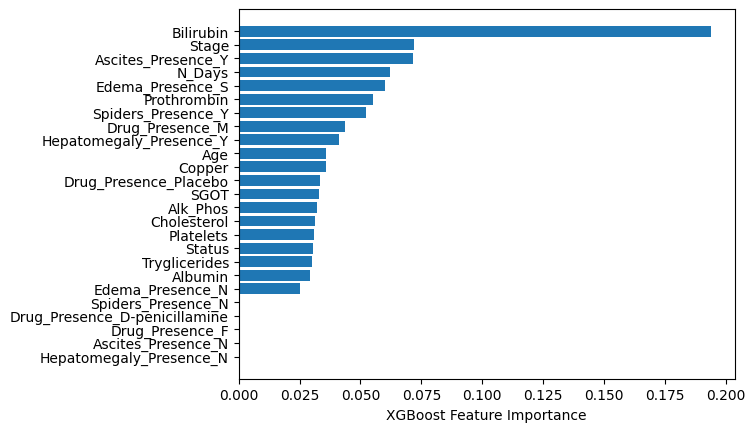

In [90]:
sorted_idx = xgb_hpt_optimized.feature_importances_.argsort()
plt.barh(df_afterfe.columns[sorted_idx], xgb_hpt_optimized.feature_importances_[sorted_idx])
plt.xlabel("XGBoost Feature Importance")